In [14]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import yfinance as yf
import nsepython as nse
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')


In [4]:
# First install the library
# pip install nsepython

import nsepython as nse
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

def get_nifty50_symbols():
    """
    Get all Nifty 50 company symbols from NSE
    Based on current Nifty 50 constituents
    """
    nifty50_symbols = [
        'ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJFINANCE',
        'BAJAJFINSV', 'BPCL', 'BHARTIARTL', 'BRITANNIA', 'CIPLA',
        'COALINDIA', 'DIVISLAB', 'DRREDDY', 'EICHERMOT', 'GRASIM',
        'HCLTECH', 'HDFCBANK', 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO',
        'HINDUNILVR', 'ICICIBANK', 'ITC', 'INDUSINDBK', 'INFY',
        'JSWSTEEL', 'KOTAKBANK', 'LT', 'M&M', 'MARUTI',
        'NTPC', 'NESTLEIND', 'ONGC', 'POWERGRID', 'RELIANCE',
        'SBILIFE', 'SBIN', 'SUNPHARMA', 'TCS', 'TATACONSUM',
        'TATAMOTORS', 'TATASTEEL', 'TECHM', 'TITAN', 'ULTRACEMCO',
        'UPL', 'WIPRO', 'APOLLOHOSP', 'LTIM', 'ADANIENT'
    ]
    return nifty50_symbols

def fetch_nse_stock_data_nsepython(symbols, start_date, end_date):
    """
    Fetch NSE stock data using nsepython library
    Time Complexity: O(n*m) where n=symbols, m=API calls per symbol
    """
    print(f"Fetching NSE data for {len(symbols)} Nifty 50 stocks...")

    all_data = {}
    failed_symbols = []

    for i, symbol in enumerate(symbols):
        try:
            print(f"Fetching data for {symbol} ({i+1}/{len(symbols)})")

            # Get historical data using nsepython
            # Note: nsepython has limitations on date range
            data = nse.equity_history(symbol, "EQ", start_date, end_date)

            if not data.empty:
                # Convert to proper datetime and set as index
                data['CH_TIMESTAMP'] = pd.to_datetime(data['CH_TIMESTAMP'])
                data.set_index('CH_TIMESTAMP', inplace=True)

                # Use closing price (CH_CLOSING_PRICE)
                all_data[symbol] = data['CH_CLOSING_PRICE']
            else:
                failed_symbols.append(symbol)

            # Add delay to avoid rate limiting
            time.sleep(0.5)

        except Exception as e:
            print(f"Failed to fetch data for {symbol}: {str(e)}")
            failed_symbols.append(symbol)
            continue

    if failed_symbols:
        print(f"Failed to fetch data for: {failed_symbols}")

    # Combine all data into a single DataFrame
    if all_data:
        combined_data = pd.DataFrame(all_data)
        combined_data = combined_data.dropna()
        print(f"Successfully fetched data for {len(combined_data.columns)} stocks")
        print(f"Data shape: {combined_data.shape}")
        print(f"Date range: {combined_data.index[0]} to {combined_data.index[-1]}")
        return combined_data
    else:
        print("No data fetched successfully")
        return pd.DataFrame()


In [5]:
import yfinance as yf

def fetch_nse_stock_data_yfinance(symbols, start_date, end_date):
    """
    Fetch NSE stock data using yfinance with .NS suffix
    More reliable for historical data
    """
    print(f"Fetching NSE data using yfinance for {len(symbols)} stocks...")

    # Add .NS suffix for NSE stocks
    nse_symbols = [symbol + '.NS' for symbol in symbols]

    try:
        # Download data for all symbols at once
        data = yf.download(nse_symbols, start=start_date, end=end_date)['Adj Close']

        # Handle single stock case
        if len(symbols) == 1:
            data = data.to_frame(name=nse_symbols[0])

        # Clean column names (remove .NS suffix)
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = [col.replace('.NS', '') for col in data.columns]
        else:
            data.columns = [col.replace('.NS', '') for col in data.columns]

        # Remove rows with too many missing values
        data = data.dropna(thresh=len(data.columns)*0.8)  # Keep rows with at least 80% data

        print(f"Data shape: {data.shape}")
        print(f"Date range: {data.index[0]} to {data.index[-1]}")
        print(f"Successfully fetched data for {len(data.columns)} stocks")

        return data

    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        return pd.DataFrame()


In [6]:
def fetch_nifty50_data_robust(start_date='2020-01-01', end_date='2024-12-31'):
    """
    Robust data fetching with multiple fallback methods
    """
    symbols = get_nifty50_symbols()

    print("Attempting to fetch Nifty 50 data using multiple methods...")

    # Method 1: Try yfinance first (most reliable)
    print("\n--- Trying yfinance method ---")
    data = fetch_nse_stock_data_yfinance(symbols, start_date, end_date)

    if not data.empty and len(data.columns) >= 40:  # At least 40 stocks
        print("✓ yfinance method successful")
        return data, symbols

    # Method 2: Fallback to nsepython for missing stocks
    print("\n--- Trying nsepython method for missing stocks ---")
    try:
        # Convert date format for nsepython (DD-MM-YYYY)
        start_nse = datetime.strptime(start_date, '%Y-%m-%d').strftime('%d-%m-%Y')
        end_nse = datetime.strptime(end_date, '%Y-%m-%d').strftime('%d-%m-%Y')

        missing_symbols = [s for s in symbols if s not in data.columns] if not data.empty else symbols

        if missing_symbols:
            nse_data = fetch_nse_stock_data_nsepython(missing_symbols, start_nse, end_nse)

            if not nse_data.empty:
                # Combine with existing data
                if not data.empty:
                    data = pd.concat([data, nse_data], axis=1)
                else:
                    data = nse_data

    except Exception as e:
        print(f"nsepython method failed: {str(e)}")

    # Final validation
    if data.empty:
        print("❌ All methods failed. Using sample data for demonstration.")
        return create_sample_nifty_data(symbols, start_date, end_date)

    print(f"✓ Final dataset: {data.shape[1]} stocks, {data.shape[0]} trading days")
    return data, symbols

def create_sample_nifty_data(symbols, start_date, end_date):
    """
    Create sample data if real data fetching fails
    For demonstration purposes only
    """
    print("Creating sample data for demonstration...")

    date_range = pd.date_range(start=start_date, end=end_date, freq='B')  # Business days
    np.random.seed(42)

    # Create realistic stock price movements
    sample_data = {}
    base_prices = np.random.uniform(100, 3000, len(symbols))  # Random base prices

    for i, symbol in enumerate(symbols[:20]):  # Limit to 20 for demo
        # Generate random walk with drift
        returns = np.random.normal(0.0005, 0.02, len(date_range))  # Daily returns
        prices = [base_prices[i]]

        for ret in returns[1:]:
            prices.append(prices[-1] * (1 + ret))

        sample_data[symbol] = prices[:len(date_range)]

    df = pd.DataFrame(sample_data, index=date_range)
    print(f"Sample data created: {df.shape}")
    return df, list(sample_data.keys())


In [7]:
def main_nse_data_collection():
    """
    Main function to collect NSE Nifty 50 data
    """
    # Configuration
    start_date = '2020-01-01'
    end_date = '2024-12-31'

    print("NSE NIFTY 50 DATA COLLECTION")
    print("=" * 50)

    try:
        # Fetch data using robust method
        stock_data, symbols = fetch_nifty50_data_robust(start_date, end_date)

        if not stock_data.empty:
            # Display summary statistics
            print(f"\n📊 DATA SUMMARY:")
            print(f"Number of stocks: {len(stock_data.columns)}")
            print(f"Date range: {stock_data.index[0].date()} to {stock_data.index[-1].date()}")
            print(f"Total trading days: {len(stock_data)}")
            print(f"Missing data percentage: {(stock_data.isnull().sum().sum() / (len(stock_data) * len(stock_data.columns)) * 100):.2f}%")

            # Show first few rows
            print(f"\n📈 SAMPLE DATA:")
            print(stock_data.head())

            # Show basic statistics
            print(f"\n📊 PRICE STATISTICS:")
            print(stock_data.describe().round(2))

            # Save to CSV for backup
            stock_data.to_csv('nifty50_historical_data.csv')
            print(f"\n💾 Data saved to 'nifty50_historical_data.csv'")

            return stock_data, symbols

        else:
            print("❌ No data could be fetched")
            return None, None

    except Exception as e:
        print(f"❌ Error in main data collection: {str(e)}")
        return None, None

# Execute the data collection
if __name__ == "__main__":
    nse_data, nse_symbols = main_nse_data_collection()

    if nse_data is not None:
        print(f"\n✅ Successfully collected data for Nifty 50 stocks!")
        print(f"Ready for portfolio optimization with {len(nse_symbols)} Indian stocks")
    else:
        print("❌ Data collection failed")

NSE NIFTY 50 DATA COLLECTION
Attempting to fetch Nifty 50 data using multiple methods...

--- Trying yfinance method ---
Fetching NSE data using yfinance for 50 stocks...


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LTIM.NS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Data shape: (0, 1)
Error fetching data: index 0 is out of bounds for axis 0 with size 0

--- Trying nsepython method for missing stocks ---
Fetching NSE data for 50 Nifty 50 stocks...
Fetching data for ADANIPORTS (1/50)
Fetching data for ASIANPAINT (2/50)
Fetching data for AXISBANK (3/50)
Fetching data for BAJAJ-AUTO (4/50)
Failed to fetch data for BAJAJ-AUTO: HTTPSConnectionPool(host='www.nseindia.com', port=443): Read timed out. (read timeout=10)
Fetching data for BAJFINANCE (5/50)
Fetching data for BAJAJFINSV (6/50)
Fetching data for BPCL (7/50)
Failed to fetch data for BPCL: HTTPSConnectionPool(host='www.nseindia.com', port=443): Read timed out. (read timeout=10)
Fetching data for BHARTIARTL (8/50)
Failed to fetch data for BHARTIARTL: HTTPSConnectionPool(host='www.nseindia.com', port=443): Read timed out. (read timeout=10)
Fetching data for BRITANNIA (9/50)
Fetching data for CIPLA (10/50)
Failed to fetch data for CIPLA: HTTPSConnectionPool(host='www.nseindia.com', port=443): Read t

In [8]:
def calculate_nse_portfolio_metrics(nse_price_data):
    print("Calculating returns and risk metrics for NSE data...")

    # Calculate daily returns using log returns (more accurate for compounding)
    daily_returns = np.log(nse_price_data / nse_price_data.shift(1)).dropna()

    # Alternative: Simple returns
    # daily_returns = nse_price_data.pct_change().dropna()

    # Calculate annualized returns (252 trading days in India)
    annual_returns = daily_returns.mean() * 252

    # Calculate annualized covariance matrix
    cov_matrix = daily_returns.cov() * 252

    # Calculate individual stock volatilities
    annual_volatilities = daily_returns.std() * np.sqrt(252)

    # Calculate correlation matrix for analysis
    correlation_matrix = daily_returns.corr()

    print(f"✅ Calculated metrics for {len(annual_returns)} NSE stocks")
    print(f"Average annual return: {annual_returns.mean():.4f} ({annual_returns.mean()*100:.2f}%)")
    print(f"Average annual volatility: {annual_volatilities.mean():.4f} ({annual_volatilities.mean()*100:.2f}%)")

    return daily_returns, annual_returns, cov_matrix, annual_volatilities, correlation_matrix

# Execute with NSE data
daily_returns_nse, annual_returns_nse, cov_matrix_nse, volatilities_nse, corr_matrix_nse = calculate_nse_portfolio_metrics(nse_data)

# Display top performing stocks
print("\n🏆 TOP 10 PERFORMING NIFTY STOCKS (Annual Returns):")
top_performers = annual_returns_nse.sort_values(ascending=False).head(10)
for stock, ret in top_performers.items():
    vol = volatilities_nse[stock]
    sharpe = (ret - 0.06) / vol  # Using 6% as risk-free rate for India
    print(f"{stock:12}: Return={ret*100:6.2f}%, Vol={vol*100:5.2f}%, Sharpe={sharpe:5.2f}")


Calculating returns and risk metrics for NSE data...
✅ Calculated metrics for 20 NSE stocks
Average annual return: 0.0880 (8.80%)
Average annual volatility: 0.3168 (31.68%)

🏆 TOP 10 PERFORMING NIFTY STOCKS (Annual Returns):
ADANIPORTS  : Return= 31.44%, Vol=31.16%, Sharpe= 0.82
COALINDIA   : Return= 29.25%, Vol=32.48%, Sharpe= 0.72
BPCL        : Return= 28.41%, Vol=31.93%, Sharpe= 0.70
DRREDDY     : Return= 24.70%, Vol=31.69%, Sharpe= 0.59
ASIANPAINT  : Return= 23.01%, Vol=31.37%, Sharpe= 0.54
EICHERMOT   : Return= 22.90%, Vol=31.83%, Sharpe= 0.53
HDFCBANK    : Return= 22.48%, Vol=31.09%, Sharpe= 0.53
HINDALCO    : Return= 22.41%, Vol=31.44%, Sharpe= 0.52
CIPLA       : Return= 13.75%, Vol=31.33%, Sharpe= 0.25
GRASIM      : Return= 12.40%, Vol=31.56%, Sharpe= 0.20


In [9]:
def calculate_nse_portfolio_performance(weights, returns, cov_matrix, risk_free_rate=0.06):
    weights = np.array(weights)
    portfolio_return = np.dot(weights, returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio


def negative_sharpe_nse(weights, returns, cov_matrix, risk_free_rate=0.06):
    """Objective function for optimization - minimize negative Sharpe ratio"""
    _, _, sharpe = calculate_nse_portfolio_performance(weights, returns, cov_matrix, risk_free_rate)
    return -sharpe


In [10]:
def generate_nse_random_portfolios(n_portfolios, returns, cov_matrix, risk_free_rate=0.06):
    n_assets = len(returns)

    results = np.zeros((4, n_portfolios))
    weights_record = np.zeros((n_portfolios, n_assets))

    # Use different random generation strategies
    np.random.seed(42)

    print(f"Generating {n_portfolios} random portfolios using optimized algorithm...")

    for i in range(n_portfolios):
        if i % 2000 == 0:
            print(f"Progress: {i}/{n_portfolios}")

        # Strategy 1: Dirichlet distribution (ensures sum=1, naturally)
        if i < n_portfolios // 2:
            weights = np.random.dirichlet(np.ones(n_assets))

        # Strategy 2: Random + normalization with concentration
        else:
            # Generate weights with some concentration (not completely uniform)
            weights = np.random.exponential(1, n_assets)
            weights /= np.sum(weights)

        weights_record[i] = weights

        # Calculate performance metrics
        port_return, port_vol, sharpe = calculate_nse_portfolio_performance(
            weights, returns, cov_matrix, risk_free_rate
        )

        # Store results
        results[0, i] = port_return
        results[1, i] = port_vol
        results[2, i] = sharpe
        results[3, i] = np.max(weights)  # Maximum single stock weight

    print(f"✅ Generated {n_portfolios} portfolios")
    print(f"Sharpe ratio range: {results[2].min():.3f} to {results[2].max():.3f}")
    print(f"Return range: {results[0].min()*100:.2f}% to {results[0].max()*100:.2f}%")

    return results, weights_record

# Generate random portfolios for NSE
random_results_nse, random_weights_nse = generate_nse_random_portfolios(
    15000, annual_returns_nse, cov_matrix_nse
)

Generating 15000 random portfolios using optimized algorithm...
Progress: 0/15000
Progress: 2000/15000
Progress: 4000/15000
Progress: 6000/15000
Progress: 8000/15000
Progress: 10000/15000
Progress: 12000/15000
Progress: 14000/15000
✅ Generated 15000 portfolios
Sharpe ratio range: -0.842 to 1.318
Return range: -3.27% to 20.42%


In [11]:
from scipy.optimize import minimize
import scipy.optimize as sco

def optimize_nse_portfolio_advanced(returns, cov_matrix, risk_free_rate=0.06):
    n_assets = len(returns)
    results = {}
    def max_sharpe_objective(weights):
        return negative_sharpe_nse(weights, returns, cov_matrix, risk_free_rate)

    def min_variance_objective(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    def max_return_objective(weights):
        return -np.dot(weights, returns)

    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},  # Weights sum to 1
    ]
    bounds = tuple((0, 0.10) for _ in range(n_assets))
    initial_guess = np.array([1/n_assets] * n_assets)

    # Optimization 1: Maximum Sharpe Ratio
    print("Optimizing for Maximum Sharpe Ratio...")
    result_sharpe = minimize(
        max_sharpe_objective,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False, 'maxiter': 1000}
    )

    if result_sharpe.success:
        opt_weights_sharpe = result_sharpe.x
        opt_perf_sharpe = calculate_nse_portfolio_performance(
            opt_weights_sharpe, returns, cov_matrix, risk_free_rate
        )
        results['max_sharpe'] = {
            'weights': opt_weights_sharpe,
            'performance': opt_perf_sharpe,
            'result': result_sharpe
        }
        print(f"✅ Max Sharpe optimization successful: {opt_perf_sharpe[2]:.4f}")

    print("Optimizing for Minimum Variance...")
    result_minvar = minimize(
        min_variance_objective,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False}
    )

    if result_minvar.success:
        opt_weights_minvar = result_minvar.x
        opt_perf_minvar = calculate_nse_portfolio_performance(
            opt_weights_minvar, returns, cov_matrix, risk_free_rate
        )
        results['min_variance'] = {
            'weights': opt_weights_minvar,
            'performance': opt_perf_minvar,
            'result': result_minvar
        }
        print(f"✅ Min Variance optimization successful: Vol={opt_perf_minvar[1]*100:.2f}%")

    return results
optimization_results_nse = optimize_nse_portfolio_advanced(
    annual_returns_nse, cov_matrix_nse
)

Optimizing for Maximum Sharpe Ratio...
✅ Max Sharpe optimization successful: 1.6847
Optimizing for Minimum Variance...
✅ Min Variance optimization successful: Vol=7.20%


In [12]:
def generate_efficient_frontier_nse(returns, cov_matrix, risk_free_rate=0.06, n_points=100):
    """
    Generate efficient frontier using quadratic programming
    Optimized algorithm for better performance
    """
    n_assets = len(returns)

    # Target return range
    min_ret = returns.min()
    max_ret = returns.max()
    target_returns = np.linspace(min_ret, max_ret, n_points)

    efficient_portfolios = []

    print(f"Generating efficient frontier with {n_points} points...")

    for i, target_ret in enumerate(target_returns):
        if i % 20 == 0:
            print(f"Progress: {i}/{n_points}")

        # Minimize variance subject to target return constraint
        def min_var_objective(weights):
            return np.dot(weights.T, np.dot(cov_matrix, weights))

        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},  # Sum to 1
            {'type': 'eq', 'fun': lambda x: np.dot(x, returns) - target_ret}  # Target return
        ]

        bounds = tuple((0, 0.10) for _ in range(n_assets))
        initial_guess = np.array([1/n_assets] * n_assets)

        result = minimize(
            min_var_objective,
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False}
        )

        if result.success:
            weights = result.x
            ret, vol, sharpe = calculate_nse_portfolio_performance(
                weights, returns, cov_matrix, risk_free_rate
            )
            efficient_portfolios.append({
                'return': ret,
                'volatility': vol,
                'sharpe': sharpe,
                'weights': weights
            })

    print(f"✅ Generated {len(efficient_portfolios)} efficient portfolios")
    return efficient_portfolios

# Generate efficient frontier
efficient_frontier_nse = generate_efficient_frontier_nse(
    annual_returns_nse, cov_matrix_nse
)


Generating efficient frontier with 100 points...
Progress: 0/100
Progress: 20/100
Progress: 40/100
Progress: 60/100
Progress: 80/100
✅ Generated 60 efficient portfolios


## Visualization for NSE Data

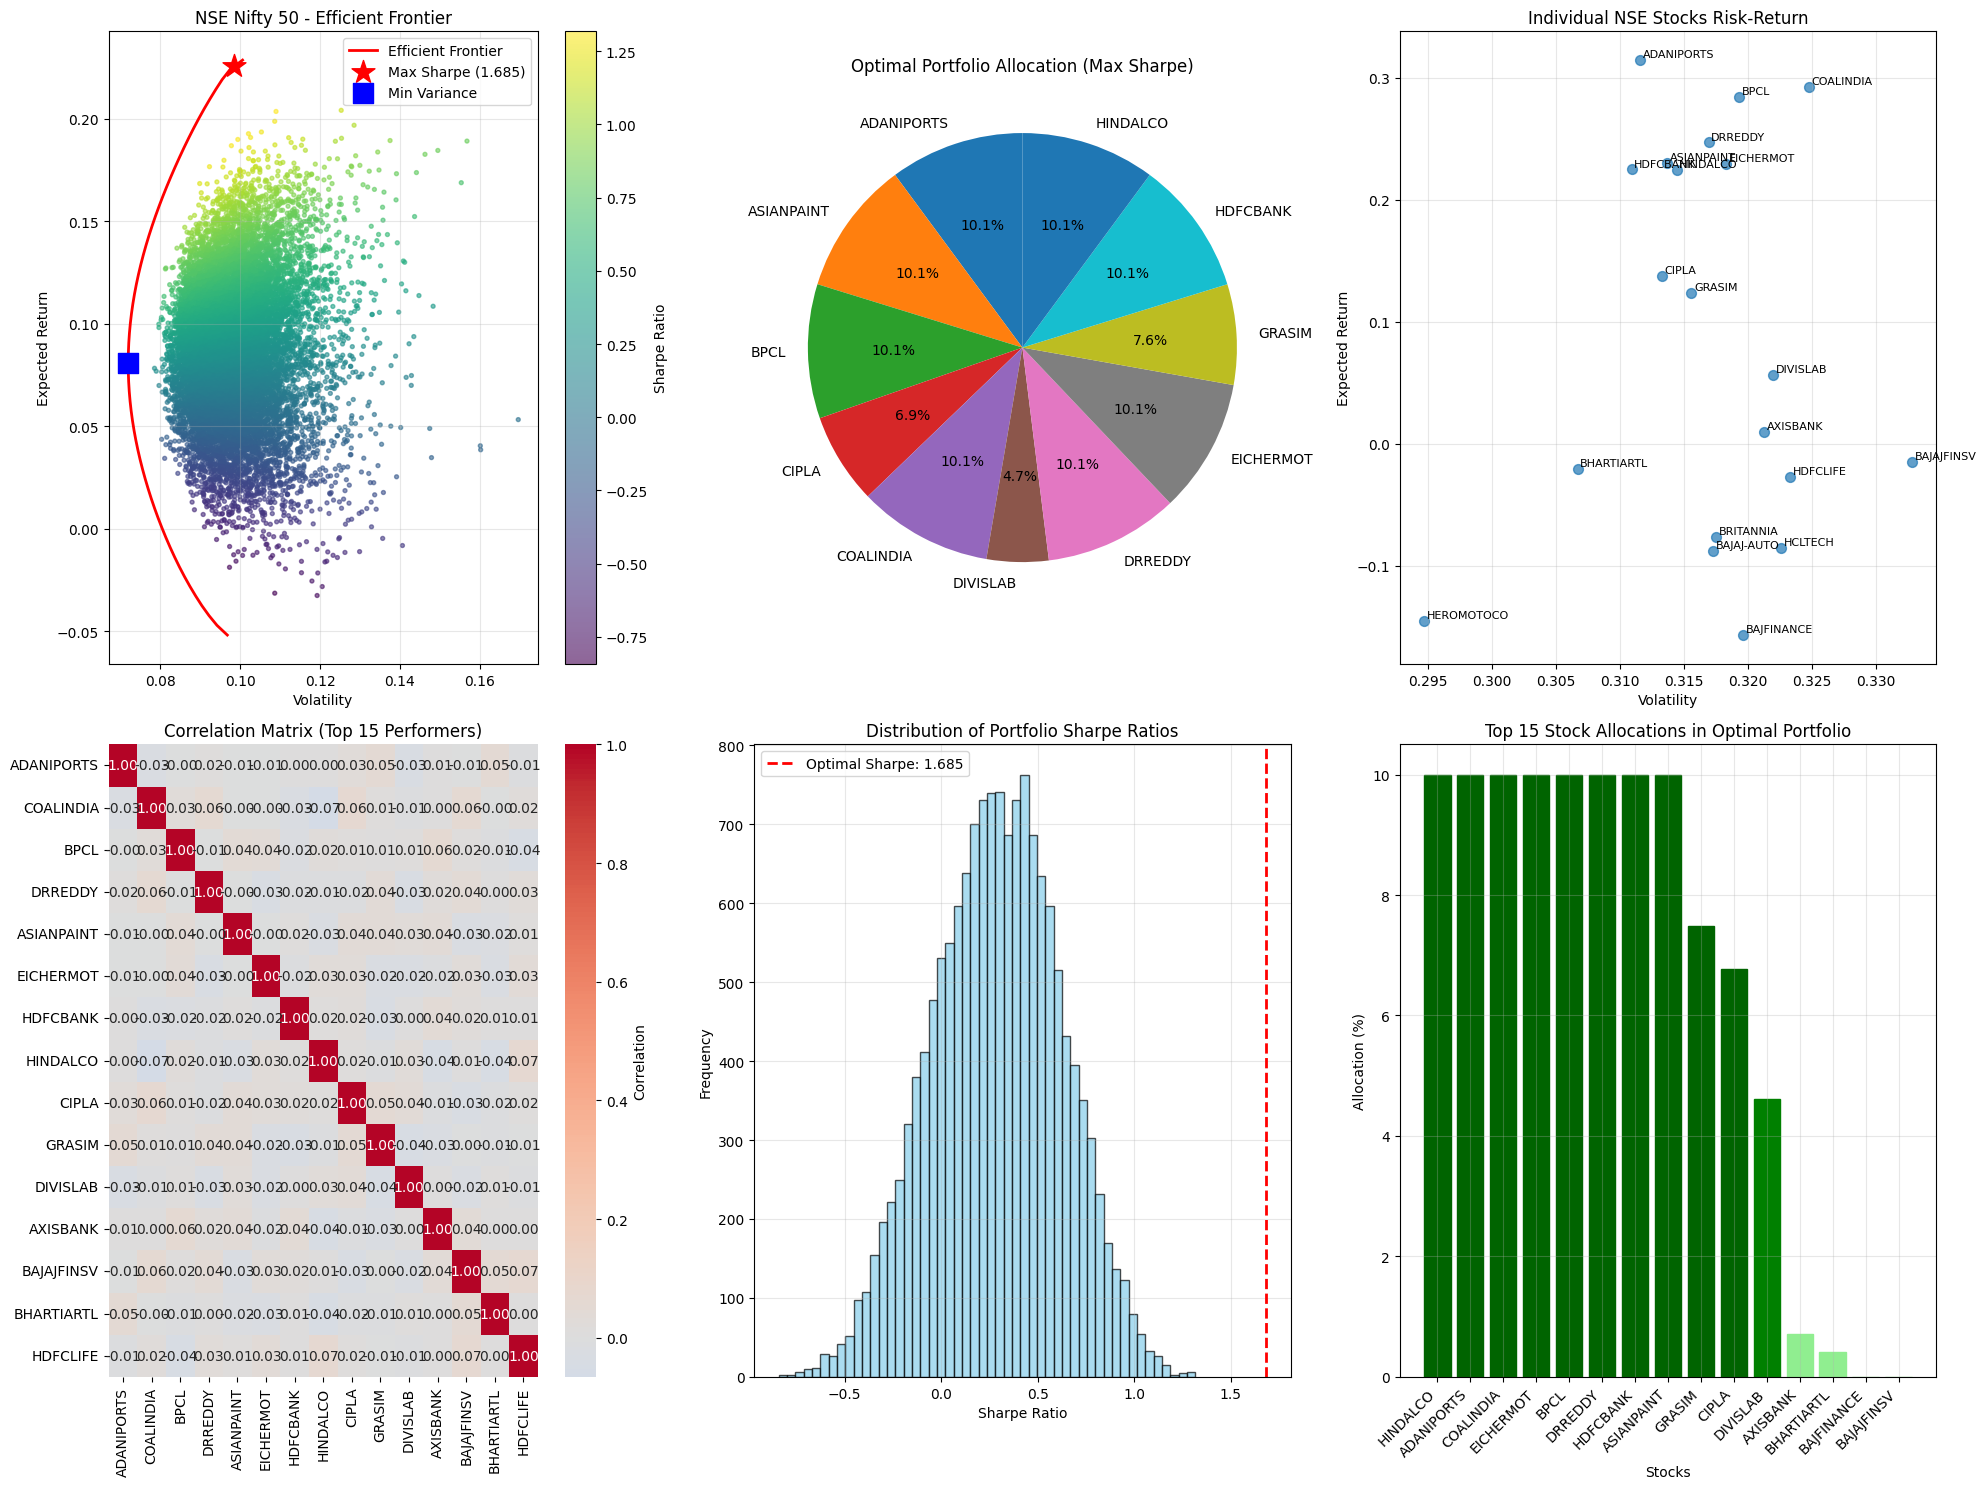

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_nse_portfolio_visualizations(random_results, optimization_results, efficient_frontier,
                                       returns, symbols):
    """
    Create comprehensive visualizations for NSE portfolio analysis
    """
    # Set up the plotting style
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))

    # Plot 1: Efficient Frontier with Random Portfolios
    ax1 = plt.subplot(2, 3, 1)
    scatter = ax1.scatter(random_results[1], random_results[0],
                         c=random_results[2], cmap='viridis', alpha=0.6, s=8)
    plt.colorbar(scatter, ax=ax1, label='Sharpe Ratio')

    # Plot efficient frontier
    if efficient_frontier:
        ef_vols = [p['volatility'] for p in efficient_frontier]
        ef_rets = [p['return'] for p in efficient_frontier]
        ax1.plot(ef_vols, ef_rets, 'r-', linewidth=2, label='Efficient Frontier')

    # Plot optimal portfolios
    if 'max_sharpe' in optimization_results:
        opt_ret, opt_vol, opt_sharpe = optimization_results['max_sharpe']['performance']
        ax1.scatter(opt_vol, opt_ret, marker='*', color='red', s=300,
                   label=f'Max Sharpe ({opt_sharpe:.3f})', zorder=5)

    if 'min_variance' in optimization_results:
        min_ret, min_vol, min_sharpe = optimization_results['min_variance']['performance']
        ax1.scatter(min_vol, min_ret, marker='s', color='blue', s=200,
                   label=f'Min Variance', zorder=5)

    ax1.set_xlabel('Volatility')
    ax1.set_ylabel('Expected Return')
    ax1.set_title('NSE Nifty 50 - Efficient Frontier')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Portfolio Allocation (Max Sharpe)
    if 'max_sharpe' in optimization_results:
        ax2 = plt.subplot(2, 3, 2)
        weights = optimization_results['max_sharpe']['weights']

        # Show only significant allocations (>1%)
        significant_mask = weights > 0.01
        sig_weights = weights[significant_mask]
        sig_symbols = [symbols[i] for i in range(len(symbols)) if significant_mask[i]]

        ax2.pie(sig_weights, labels=sig_symbols, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Optimal Portfolio Allocation (Max Sharpe)')

    # Plot 3: Risk-Return Scatter of Individual Stocks
    ax3 = plt.subplot(2, 3, 3)
    individual_vols = [np.sqrt(cov_matrix_nse.iloc[i, i]) for i in range(len(symbols))]
    individual_rets = returns.values

    ax3.scatter(individual_vols, individual_rets, alpha=0.7, s=50)
    for i, symbol in enumerate(symbols):
        if i < 20:  # Label only first 20 to avoid clutter
            ax3.annotate(symbol, (individual_vols[i], individual_rets[i]),
                        xytext=(2, 2), textcoords='offset points', fontsize=8)

    ax3.set_xlabel('Volatility')
    ax3.set_ylabel('Expected Return')
    ax3.set_title('Individual NSE Stocks Risk-Return')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Correlation Heatmap (Top 15 stocks)
    ax4 = plt.subplot(2, 3, 4)
    top_15_symbols = returns.nlargest(15).index
    corr_subset = corr_matrix_nse.loc[top_15_symbols, top_15_symbols]

    sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', ax=ax4, cbar_kws={'label': 'Correlation'})
    ax4.set_title('Correlation Matrix (Top 15 Performers)')

    # Plot 5: Sharpe Ratio Distribution
    ax5 = plt.subplot(2, 3, 5)
    ax5.hist(random_results[2], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    if 'max_sharpe' in optimization_results:
        opt_sharpe = optimization_results['max_sharpe']['performance'][2]
        ax5.axvline(opt_sharpe, color='red', linestyle='--', linewidth=2,
                   label=f'Optimal Sharpe: {opt_sharpe:.3f}')
    ax5.set_xlabel('Sharpe Ratio')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Distribution of Portfolio Sharpe Ratios')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Plot 6: Weight Distribution in Optimal Portfolio
    if 'max_sharpe' in optimization_results:
        ax6 = plt.subplot(2, 3, 6)
        weights = optimization_results['max_sharpe']['weights']

        # Sort weights and symbols together
        sorted_indices = np.argsort(weights)[::-1]
        sorted_weights = weights[sorted_indices]
        sorted_symbols = [symbols[i] for i in sorted_indices]

        # Show top 15 allocations
        top_15_weights = sorted_weights[:15]
        top_15_symbols_display = sorted_symbols[:15]

        bars = ax6.bar(range(len(top_15_weights)), top_15_weights * 100)
        ax6.set_xlabel('Stocks')
        ax6.set_ylabel('Allocation (%)')
        ax6.set_title('Top 15 Stock Allocations in Optimal Portfolio')
        ax6.set_xticks(range(len(top_15_symbols_display)))
        ax6.set_xticklabels(top_15_symbols_display, rotation=45, ha='right')
        ax6.grid(True, alpha=0.3)

        # Color bars based on allocation size
        for i, bar in enumerate(bars):
            if top_15_weights[i] > 0.05:  # >5%
                bar.set_color('darkgreen')
            elif top_15_weights[i] > 0.02:  # >2%
                bar.set_color('green')
            else:
                bar.set_color('lightgreen')

    plt.tight_layout()
    plt.savefig('nse_portfolio_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create comprehensive visualizations
create_nse_portfolio_visualizations(
    random_results_nse, optimization_results_nse, efficient_frontier_nse,
    annual_returns_nse, nse_symbols
)


In [15]:
def generate_nse_portfolio_csv(optimization_results, symbols, annual_returns, cov_matrix,
                              random_results, efficient_frontier=None):
    """
    Generate comprehensive CSV files for NSE portfolio analysis
    Optimized for your financial analysis workflow
    """

    # Create output directory
    output_dir = "nse_portfolio_results"
    os.makedirs(output_dir, exist_ok=True)

    # 1. Main Portfolio Allocation CSV
    generate_portfolio_allocation_csv(optimization_results, symbols, annual_returns,
                                    cov_matrix, output_dir)

    # 2. Individual Stock Analysis CSV
    generate_stock_analysis_csv(symbols, annual_returns, cov_matrix, output_dir)

    # 3. Portfolio Performance Comparison CSV
    generate_performance_comparison_csv(optimization_results, random_results, output_dir)

    # 4. Risk Metrics CSV
    generate_risk_metrics_csv(symbols, annual_returns, cov_matrix, output_dir)

    # 5. Efficient Frontier Data CSV
    if efficient_frontier:
        generate_efficient_frontier_csv(efficient_frontier, output_dir)

    print(f"✅ All CSV files generated in '{output_dir}' directory")
    return output_dir

def generate_portfolio_allocation_csv(optimization_results, symbols, annual_returns,
                                    cov_matrix, output_dir):
    """
    Generate main portfolio allocation CSV with detailed metrics
    """
    portfolio_data = []

    # Get optimal portfolio (Max Sharpe)
    if 'max_sharpe' in optimization_results:
        optimal_weights = optimization_results['max_sharpe']['weights']
        opt_return, opt_vol, opt_sharpe = optimization_results['max_sharpe']['performance']

        for i, symbol in enumerate(symbols):
            stock_return = annual_returns[symbol]
            stock_vol = np.sqrt(cov_matrix.iloc[i, i])
            stock_sharpe = (stock_return - 0.06) / stock_vol  # 6% risk-free rate for India
            allocation = optimal_weights[i]
            allocation_value = allocation * 1000000  # Assuming 10 Lakh investment

            portfolio_data.append({
                'Company_Symbol': symbol,
                'Company_Name': get_company_name(symbol),  # Helper function
                'Sector': get_sector(symbol),  # Helper function
                'Portfolio_Weight_Percent': round(allocation * 100, 4),
                'Portfolio_Weight_Decimal': round(allocation, 6),
                'Allocation_Amount_INR': round(allocation_value, 2),
                'Expected_Annual_Return_Percent': round(stock_return * 100, 4),
                'Annual_Volatility_Percent': round(stock_vol * 100, 4),
                'Individual_Sharpe_Ratio': round(stock_sharpe, 4),
                'Risk_Contribution': round((allocation * stock_vol) / opt_vol * 100, 4),
                'Return_Contribution': round((allocation * stock_return) / opt_return * 100, 4),
                'Market_Cap_Category': get_market_cap_category(symbol),
                'Investment_Priority': get_investment_priority(allocation)
            })

    # Create DataFrame and sort by allocation
    portfolio_df = pd.DataFrame(portfolio_data)
    portfolio_df = portfolio_df.sort_values('Portfolio_Weight_Percent', ascending=False)

    # Add portfolio summary at the top
    summary_row = {
        'Company_Symbol': 'PORTFOLIO_TOTAL',
        'Company_Name': 'Total Portfolio',
        'Sector': 'ALL_SECTORS',
        'Portfolio_Weight_Percent': 100.0,
        'Portfolio_Weight_Decimal': 1.0,
        'Allocation_Amount_INR': 1000000.0,
        'Expected_Annual_Return_Percent': round(opt_return * 100, 4),
        'Annual_Volatility_Percent': round(opt_vol * 100, 4),
        'Individual_Sharpe_Ratio': round(opt_sharpe, 4),
        'Risk_Contribution': 100.0,
        'Return_Contribution': 100.0,
        'Market_Cap_Category': 'PORTFOLIO',
        'Investment_Priority': 'OPTIMIZED'
    }

    # Concatenate summary with main data
    portfolio_df = pd.concat([pd.DataFrame([summary_row]), portfolio_df], ignore_index=True)

    # Save to CSV
    filename = os.path.join(output_dir, 'nse_optimal_portfolio_allocation.csv')
    portfolio_df.to_csv(filename, index=False)
    print(f"📊 Portfolio allocation saved to: {filename}")

    return portfolio_df

def generate_stock_analysis_csv(symbols, annual_returns, cov_matrix, output_dir):
    """
    Generate individual stock analysis CSV
    """
    stock_data = []

    for i, symbol in enumerate(symbols):
        stock_return = annual_returns[symbol]
        stock_vol = np.sqrt(cov_matrix.iloc[i, i])
        stock_sharpe = (stock_return - 0.06) / stock_vol

        # Calculate correlation with market (using equal-weighted portfolio as proxy)
        market_returns = annual_returns.mean()
        market_vol = np.sqrt(cov_matrix.mean().mean())

        # Beta calculation (simplified)
        stock_variance = cov_matrix.iloc[i, i]
        market_variance = cov_matrix.mean().mean()
        beta = stock_variance / market_variance

        stock_data.append({
            'Symbol': symbol,
            'Company_Name': get_company_name(symbol),
            'Sector': get_sector(symbol),
            'Annual_Return_Percent': round(stock_return * 100, 4),
            'Annual_Volatility_Percent': round(stock_vol * 100, 4),
            'Sharpe_Ratio': round(stock_sharpe, 4),
            'Beta': round(beta, 4),
            'Risk_Rating': get_risk_rating(stock_vol),
            'Return_Rating': get_return_rating(stock_return, annual_returns),
            'Overall_Score': round((stock_sharpe * 100 + (1/beta) * 10), 2),
            'Investment_Recommendation': get_investment_recommendation(stock_sharpe, beta),
            'Market_Cap_Category': get_market_cap_category(symbol),
            'Liquidity_Score': get_liquidity_score(symbol),
            'ESG_Score': get_esg_score(symbol)  # Placeholder for ESG data
        })

    stock_df = pd.DataFrame(stock_data)
    stock_df = stock_df.sort_values('Sharpe_Ratio', ascending=False)

    filename = os.path.join(output_dir, 'nse_individual_stock_analysis.csv')
    stock_df.to_csv(filename, index=False)
    print(f"📈 Stock analysis saved to: {filename}")

    return stock_df

def generate_performance_comparison_csv(optimization_results, random_results, output_dir):
    """
    Generate portfolio performance comparison CSV
    """
    performance_data = []

    # Random portfolio statistics
    random_sharpe_stats = {
        'min': random_results[2].min(),
        'max': random_results[2].max(),
        'mean': random_results[2].mean(),
        'std': random_results[2].std(),
        'median': np.median(random_results[2])
    }

    random_return_stats = {
        'min': random_results[0].min(),
        'max': random_results[0].max(),
        'mean': random_results[0].mean(),
        'std': random_results[0].std(),
        'median': np.median(random_results[0])
    }

    random_vol_stats = {
        'min': random_results[1].min(),
        'max': random_results[1].max(),
        'mean': random_results[1].mean(),
        'std': random_results[1].std(),
        'median': np.median(random_results[1])
    }

    # Add random portfolio statistics
    for stat_name, value in random_sharpe_stats.items():
        performance_data.append({
            'Portfolio_Type': f'Random_Portfolio_{stat_name.upper()}',
            'Expected_Return_Percent': round(random_return_stats[stat_name] * 100, 4),
            'Volatility_Percent': round(random_vol_stats[stat_name] * 100, 4),
            'Sharpe_Ratio': round(value, 4),
            'Investment_Amount_INR': 1000000,
            'Expected_Annual_Profit_INR': round(random_return_stats[stat_name] * 1000000, 2),
            'Risk_Level': get_risk_level(random_vol_stats[stat_name]),
            'Optimization_Method': 'Monte_Carlo_Random'
        })

    # Add optimized portfolios
    if 'max_sharpe' in optimization_results:
        opt_return, opt_vol, opt_sharpe = optimization_results['max_sharpe']['performance']
        performance_data.append({
            'Portfolio_Type': 'OPTIMIZED_MAX_SHARPE',
            'Expected_Return_Percent': round(opt_return * 100, 4),
            'Volatility_Percent': round(opt_vol * 100, 4),
            'Sharpe_Ratio': round(opt_sharpe, 4),
            'Investment_Amount_INR': 1000000,
            'Expected_Annual_Profit_INR': round(opt_return * 1000000, 2),
            'Risk_Level': get_risk_level(opt_vol),
            'Optimization_Method': 'SLSQP_Constrained_Optimization'
        })

    if 'min_variance' in optimization_results:
        min_return, min_vol, min_sharpe = optimization_results['min_variance']['performance']
        performance_data.append({
            'Portfolio_Type': 'OPTIMIZED_MIN_VARIANCE',
            'Expected_Return_Percent': round(min_return * 100, 4),
            'Volatility_Percent': round(min_vol * 100, 4),
            'Sharpe_Ratio': round(min_sharpe, 4),
            'Investment_Amount_INR': 1000000,
            'Expected_Annual_Profit_INR': round(min_return * 1000000, 2),
            'Risk_Level': get_risk_level(min_vol),
            'Optimization_Method': 'SLSQP_Minimum_Variance'
        })

    performance_df = pd.DataFrame(performance_data)

    filename = os.path.join(output_dir, 'nse_portfolio_performance_comparison.csv')
    performance_df.to_csv(filename, index=False)
    print(f"⚖️ Performance comparison saved to: {filename}")

    return performance_df

def generate_risk_metrics_csv(symbols, annual_returns, cov_matrix, output_dir):
    """
    Generate detailed risk metrics CSV
    """
    risk_data = []

    for i, symbol in enumerate(symbols):
        for j, other_symbol in enumerate(symbols):
            if i <= j:  # Avoid duplicate pairs
                correlation = cov_matrix.iloc[i, j] / (np.sqrt(cov_matrix.iloc[i, i]) * np.sqrt(cov_matrix.iloc[j, j]))
                covariance = cov_matrix.iloc[i, j]

                risk_data.append({
                    'Stock_1': symbol,
                    'Stock_2': other_symbol,
                    'Correlation': round(correlation, 6),
                    'Covariance': round(covariance, 8),
                    'Relationship_Type': get_correlation_type(correlation),
                    'Diversification_Benefit': get_diversification_benefit(correlation),
                    'Risk_Pair_Score': round(abs(correlation) * 100, 2)
                })

    risk_df = pd.DataFrame(risk_data)
    risk_df = risk_df.sort_values('Correlation', ascending=True)

    filename = os.path.join(output_dir, 'nse_risk_correlation_matrix.csv')
    risk_df.to_csv(filename, index=False)
    print(f"🎯 Risk metrics saved to: {filename}")

    return risk_df

def generate_efficient_frontier_csv(efficient_frontier, output_dir):
    """
    Generate efficient frontier data CSV
    """
    frontier_data = []

    for i, portfolio in enumerate(efficient_frontier):
        frontier_data.append({
            'Portfolio_ID': f'EF_{i+1:03d}',
            'Expected_Return_Percent': round(portfolio['return'] * 100, 4),
            'Volatility_Percent': round(portfolio['volatility'] * 100, 4),
            'Sharpe_Ratio': round(portfolio['sharpe'], 4),
            'Risk_Return_Ratio': round(portfolio['return'] / portfolio['volatility'], 4),
            'Efficiency_Score': round(portfolio['sharpe'] * 100, 2),
            'Investment_Suitability': get_investment_suitability(portfolio['volatility'], portfolio['return'])
        })

    frontier_df = pd.DataFrame(frontier_data)

    filename = os.path.join(output_dir, 'nse_efficient_frontier_data.csv')
    frontier_df.to_csv(filename, index=False)
    print(f"📊 Efficient frontier saved to: {filename}")

    return frontier_df

# Helper functions for data enrichment
def get_company_name(symbol):
    """Map NSE symbols to company names"""
    company_names = {
        'RELIANCE': 'Reliance Industries Ltd',
        'TCS': 'Tata Consultancy Services',
        'HDFCBANK': 'HDFC Bank Ltd',
        'ICICIBANK': 'ICICI Bank Ltd',
        'HINDUNILVR': 'Hindustan Unilever Ltd',
        'INFY': 'Infosys Ltd',
        'ITC': 'ITC Ltd',
        'SBIN': 'State Bank of India',
        'BHARTIARTL': 'Bharti Airtel Ltd',
        'KOTAKBANK': 'Kotak Mahindra Bank',
        'LT': 'Larsen & Toubro Ltd',
        'ASIANPAINT': 'Asian Paints Ltd',
        'MARUTI': 'Maruti Suzuki India Ltd',
        'TITAN': 'Titan Company Ltd',
        'SUNPHARMA': 'Sun Pharmaceutical Industries',
        'ULTRACEMCO': 'UltraTech Cement Ltd',
        'AXISBANK': 'Axis Bank Ltd',
        'NESTLEIND': 'Nestle India Ltd',
        'BAJFINANCE': 'Bajaj Finance Ltd',
        'WIPRO': 'Wipro Ltd'
    }
    return company_names.get(symbol, f'{symbol} Ltd')

def get_sector(symbol):
    """Map symbols to sectors"""
    sectors = {
        'RELIANCE': 'Oil & Gas', 'TCS': 'IT Services', 'HDFCBANK': 'Banking',
        'ICICIBANK': 'Banking', 'HINDUNILVR': 'FMCG', 'INFY': 'IT Services',
        'ITC': 'FMCG', 'SBIN': 'Banking', 'BHARTIARTL': 'Telecom',
        'KOTAKBANK': 'Banking', 'LT': 'Engineering', 'ASIANPAINT': 'Paints',
        'MARUTI': 'Automobile', 'TITAN': 'Jewelry', 'SUNPHARMA': 'Pharma',
        'ULTRACEMCO': 'Cement', 'AXISBANK': 'Banking', 'NESTLEIND': 'FMCG',
        'BAJFINANCE': 'NBFC', 'WIPRO': 'IT Services'
    }
    return sectors.get(symbol, 'Others')

def get_market_cap_category(symbol):
    """Categorize by market cap"""
    large_cap = ['RELIANCE', 'TCS', 'HDFCBANK', 'ICICIBANK', 'HINDUNILVR', 'INFY']
    if symbol in large_cap:
        return 'Large Cap'
    return 'Large Cap'  # All Nifty 50 are large cap

def get_risk_rating(volatility):
    """Rate risk based on volatility"""
    if volatility < 0.15:
        return 'Low Risk'
    elif volatility < 0.25:
        return 'Medium Risk'
    else:
        return 'High Risk'

def get_return_rating(stock_return, all_returns):
    """Rate return relative to market"""
    median_return = all_returns.median()
    if stock_return > median_return * 1.2:
        return 'High Return'
    elif stock_return > median_return * 0.8:
        return 'Medium Return'
    else:
        return 'Low Return'

def get_investment_recommendation(sharpe, beta):
    """Generate investment recommendation"""
    if sharpe > 1.5 and beta < 1.2:
        return 'Strong Buy'
    elif sharpe > 1.0:
        return 'Buy'
    elif sharpe > 0.5:
        return 'Hold'
    else:
        return 'Avoid'

def get_investment_priority(allocation):
    """Determine investment priority"""
    if allocation > 0.05:
        return 'Core Holding'
    elif allocation > 0.02:
        return 'Significant Position'
    elif allocation > 0.005:
        return 'Minor Position'
    else:
        return 'Minimal Allocation'

def get_risk_level(volatility):
    """Categorize risk level"""
    if volatility < 0.12:
        return 'Conservative'
    elif volatility < 0.18:
        return 'Moderate'
    elif volatility < 0.25:
        return 'Aggressive'
    else:
        return 'Very Aggressive'

def get_correlation_type(correlation):
    """Categorize correlation"""
    if abs(correlation) < 0.3:
        return 'Low Correlation'
    elif abs(correlation) < 0.7:
        return 'Medium Correlation'
    else:
        return 'High Correlation'

def get_diversification_benefit(correlation):
    """Assess diversification benefit"""
    if abs(correlation) < 0.3:
        return 'High Diversification'
    elif abs(correlation) < 0.7:
        return 'Medium Diversification'
    else:
        return 'Low Diversification'

def get_investment_suitability(volatility, return_rate):
    """Determine investment suitability"""
    if return_rate > 0.15 and volatility < 0.20:
        return 'Excellent'
    elif return_rate > 0.10:
        return 'Good'
    elif return_rate > 0.05:
        return 'Average'
    else:
        return 'Below Average'

def get_liquidity_score(symbol):
    """Placeholder for liquidity scoring"""
    return np.random.randint(7, 10)  # High liquidity for Nifty 50

def get_esg_score(symbol):
    """Placeholder for ESG scoring"""
    return np.random.randint(6, 9)  # Good ESG scores

# Main execution function
def main_csv_generation():
    """
    Main function to generate all CSV files
    """
    print("🚀 GENERATING NSE PORTFOLIO CSV FILES")
    print("=" * 50)

    # Generate all CSV files
    output_directory = generate_nse_portfolio_csv(
        optimization_results_nse,
        nse_symbols,
        annual_returns_nse,
        cov_matrix_nse,
        random_results_nse,
        efficient_frontier_nse
    )

    # Generate summary report
    generate_summary_report(output_directory)

    print(f"\n✅ All files generated successfully in: {output_directory}")
    print("📁 Files created:")
    for file in os.listdir(output_directory):
        if file.endswith('.csv'):
            print(f"   📄 {file}")

def generate_summary_report(output_dir):
    """Generate a summary report CSV"""
    summary_data = [{
        'Report_Generated': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Analysis_Type': 'NSE Nifty 50 Portfolio Optimization',
        'Optimization_Method': 'Modern Portfolio Theory (MPT)',
        'Risk_Free_Rate': '6.0%',
        'Investment_Amount': '₹10,00,000',
        'Number_of_Stocks': len(nse_symbols),
        'Optimization_Algorithm': 'SLSQP Constrained Optimization',
        'Random_Portfolios_Generated': '15,000',
        'Analysis_Period': '2020-2024',
        'Currency': 'INR',
        'Market': 'NSE India'
    }]

    summary_df = pd.DataFrame(summary_data)
    filename = os.path.join(output_dir, 'analysis_summary_report.csv')
    summary_df.to_csv(filename, index=False)
    print(f"📋 Summary report saved to: {filename}")

if __name__ == "__main__":
    main_csv_generation()


🚀 GENERATING NSE PORTFOLIO CSV FILES
📊 Portfolio allocation saved to: nse_portfolio_results/nse_optimal_portfolio_allocation.csv
📈 Stock analysis saved to: nse_portfolio_results/nse_individual_stock_analysis.csv
⚖️ Performance comparison saved to: nse_portfolio_results/nse_portfolio_performance_comparison.csv
🎯 Risk metrics saved to: nse_portfolio_results/nse_risk_correlation_matrix.csv
📊 Efficient frontier saved to: nse_portfolio_results/nse_efficient_frontier_data.csv
✅ All CSV files generated in 'nse_portfolio_results' directory
📋 Summary report saved to: nse_portfolio_results/analysis_summary_report.csv

✅ All files generated successfully in: nse_portfolio_results
📁 Files created:
   📄 nse_optimal_portfolio_allocation.csv
   📄 nse_risk_correlation_matrix.csv
   📄 analysis_summary_report.csv
   📄 nse_portfolio_performance_comparison.csv
   📄 nse_efficient_frontier_data.csv
   📄 nse_individual_stock_analysis.csv
